In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader

In [37]:
#based on https://towardsdatascience.com/build-a-simple-neural-network-using-pytorch-38c55158028d
n_input, n_hidden, n_out, batch_size, learning_rate = 9, 15, 1, 100, 0.01

In [16]:
train_pd = pd.read_csv('full.csv')
train_tensor = torch.tensor(train_pd.to_numpy())

In [17]:
train, validate, test = torch.utils.data.random_split(train_tensor, [28000, 2262, 2262])
train_loader = DataLoader(train, batch_size=batch_size)

In [18]:
# train_x = train_tensor[:28000, :9].float()
# train_y = train_tensor[:28000, 9:10].float()

train_x = torch.randn(batch_size, n_input)
train_y = (torch.rand(size=(batch_size, 1)) < 0.5).float()

print(train_x.shape, train_y.shape)

torch.Size([28000, 9]) torch.Size([28000, 1])


In [19]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=1, bias=True)
  (3): Sigmoid()
)


In [20]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [43]:
losses = []
for i in range(100):
    pred_y = model(train_x)
    print(model[0].weight)
    loss = loss_function(pred_y, train_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

Parameter containing:
tensor([[-0.2236, -0.0378,  0.2977, -0.2583,  0.0597,  0.0953,  0.2987, -0.3050,
         -0.0821],
        [ 0.1769,  0.1393, -0.2781, -0.2684, -0.2136, -0.2317, -0.2750,  0.3033,
         -0.1683],
        [-0.0067, -0.2471,  0.0369,  0.1657,  0.0623, -0.2846,  0.2944, -0.0534,
         -0.0699],
        [-0.1017, -0.2113, -0.2731, -0.1436, -0.1551,  0.0153,  0.0851,  0.0271,
         -0.2997],
        [ 0.0108, -0.2181, -0.1491, -0.1991, -0.0330,  0.2587, -0.1292, -0.1259,
         -0.1294],
        [ 0.0845, -0.0848, -0.1975, -0.1668, -0.2522,  0.2511, -0.3263, -0.1045,
         -0.1799],
        [ 0.2348,  0.3206,  0.2057, -0.0823,  0.0007, -0.0370, -0.2360,  0.2521,
         -0.1022],
        [ 0.2855,  0.2181,  0.0788, -0.3151, -0.3119,  0.2421,  0.2760,  0.0448,
          0.3211],
        [ 0.2238,  0.2337,  0.3041, -0.0898,  0.1652,  0.0745, -0.2122, -0.1197,
         -0.0606],
        [-0.1296,  0.0817,  0.0030,  0.2711, -0.3211,  0.2275, -0.2215, -0.219

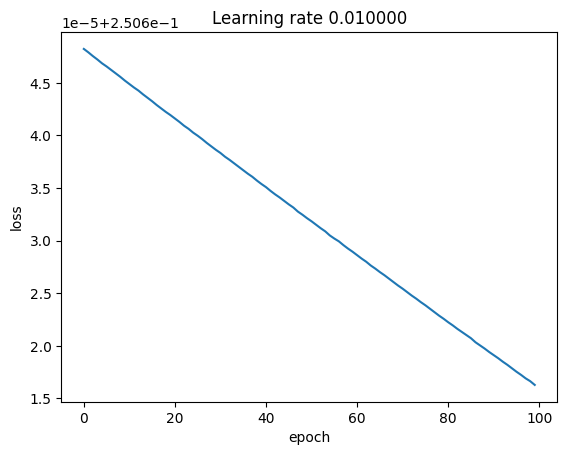

In [42]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()